In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import shift
from scipy.signal import correlate
from scipy.fft import rfft,fft
import pandas as pd
from scipy import signal
import os


def normalize(data):
    d=(data-np.min(data))/(np.max(data)-np.min(data))
    return d

def normalize_sd(signal):
    return (signal-np.mean(signal))/np.std(signal)

#get fft components of a signal
def get_fft_components(signal):
    if(len(signal)>1):
        signal=signal.squeeze()
    signal=normalize_sd(signal)
    fft_com=np.real(rfft(signal))
    return fft_com

'''
when 2 signals are correlated but not aligned in the time axis, 
use this function to get the difference of the misalignment
Assumed that signal2 is delayed than signal 1
'''
def get_idx_diff(signal1,signal2):
    sample_rate=2000 #in Hz
    lookup_time=1 # how far we cross correlate in seconds
    lookup_i=int(lookup_time*sample_rate)
    corr_list=[]
    for i in range(0,lookup_i):
        shifted=shift(signal2, i)
        cor=np.corrcoef(signal1,shifted)[0,1]
        corr_list.append(cor)
    plt.plot(corr_list)
    plt.show()
    return np.argmax(np.array(corr_list))


In [14]:
'''
Let's check how many participants we have in the dataset. 
Data for each user is stored in a unique directory which starts with 'GDN'
'''
path='/scratch/lnw8px/ECG_radar/clinical/'
dir_list=os.listdir(path)
user_list=[]
for directory in dir_list:
    if(directory[0:3]=='GDN'):
        user_list.append(directory)  

#count the number of participants
print(len(user_list))

30


In [28]:
'''
Data is taken while the participants are at different physical states.
Let's explore aht they are.
Let's go to the directory of the first participant.
'''
path='/scratch/lnw8px/ECG_radar/clinical/GDN0001/'
dir_list=os.listdir(path)
print(dir_list)
print([d.split('_')[2].split('.')[0] for d in dir_list])

['GDN0001_3_TiltUp.mat', 'GDN0001_4_TiltDown.mat', 'GDN0001_1_Resting.mat', 'GDN0001_2_Valsalva.mat']
['TiltUp', 'TiltDown', 'Resting', 'Valsalva']


In [32]:
'''
Let's read one of the data file and look what is inside it!
Since the data is stored in Matlab files we need to use a matlab-supporting library for python
scipy.io.loadmat can do this
'''

'''
We can see that there are different types of data here. 
They are :
blood pressure (tfm_bp), ECG lead1 (tfm_ecg1), ECG lead2 (tfm_ecg2),ICG data (tfm_icg), radar data which is two folds (radar_i and radar_q)
The sampling rates of these signals are also given with parameters such as fs_bp (sampling rate for blood pressure)
'''

path='/scratch/lnw8px/ECG_radar/clinical/GDN0001/GDN0001_3_TiltUp.mat'
x = loadmat(path)
x


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mi Apr 22 11:34:00 2020',
 '__version__': '1.0',
 '__globals__': [],
 'fs_bp': array([[200]], dtype=uint8),
 'fs_ecg': array([[2000]], dtype=uint16),
 'fs_icg': array([[1000]], dtype=uint16),
 'fs_intervention': array([[2000]], dtype=uint16),
 'fs_radar': array([[2000]], dtype=uint16),
 'fs_z0': array([[100]], dtype=uint8),
 'measurement_info': array([[array(['2018-02-06_11-20-55'], dtype='<U19'),
         array(['TiltUp'], dtype='<U6'), array(['GDN0001'], dtype='<U7')]],
       dtype=object),
 'radar_i': array([[1963.66453171],
        [1963.1152153 ],
        [1963.42658997],
        ...,
        [ 307.18135834],
        [ 306.77938461],
        [ 309.47971344]]),
 'radar_q': array([[-907.89031982],
        [-911.08751297],
        [-908.75816345],
        ...,
        [ 327.57377625],
        [ 325.8562088 ],
        [ 320.66583633]]),
 'tfm_bp': array([[91.99250342],
        [93.1486933 ],
        [94.17239436],
 

In [52]:
#lets plot some data!
path='/scratch/lnw8px/ECG_radar/clinical/GDN0001/GDN0001_1_Resting.mat'
x = loadmat(path)
#get sampling rate for ecg
fs_ecg=x['fs_ecg']
fs_bp=x['fs_bp']
fs_radar=x['fs_radar']
fs_icg=x['fs_icg']
ecg1=x['tfm_ecg1'].squeeze()
ecg2=x['tfm_ecg2'].squeeze()
radari=x['radar_i'].squeeze()
radarq=x['radar_q'].squeeze()
bp=x['tfm_bp'].squeeze()
icg=x['tfm_icg'].squeeze()

Text(0, 0.5, 'ECG2 (mV)')

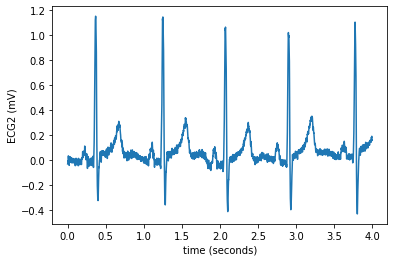

In [53]:
#plot an example of the ecg1 data
time=list(range(0,len(ecg2)))/fs_ecg[0,0]
plt.plot(time[0:8000],ecg2[0:8000])
plt.xlabel('time (seconds)')
plt.ylabel('ECG2 (mV)')

Text(0, 0.5, 'Blood pressure (mmHg)')

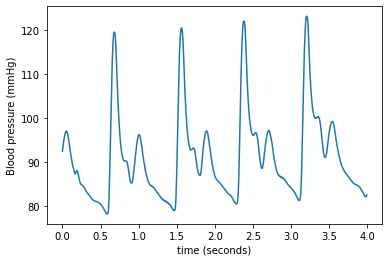

In [61]:
#plot an example of the blood pressure data
time=list(range(0,len(bp)))/fs_bp[0,0]
plt.plot(time[0:800],bp[0:800])
plt.xlabel('time (seconds)')
plt.ylabel('Blood pressure (mmHg)')

Text(0, 0.5, 'Radar_Q (mV)')

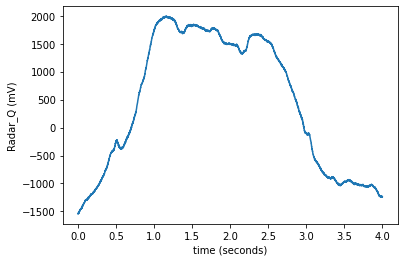

In [69]:
#plot an example of the radar_q data
time=list(range(0,len(radarq)))/fs_radar[0,0]
plt.plot(time[0:8000],radarq[0:8000])
plt.xlabel('time (seconds)')
plt.ylabel('Radar_Q (mV)')

Text(0, 0.5, 'ICG (Ohms/s)')

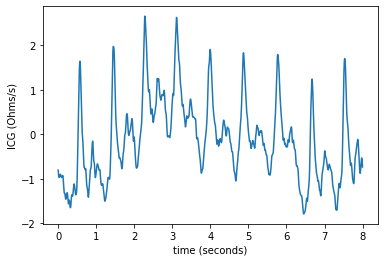

In [70]:
#plot an example of the ICG data
time=list(range(0,len(icg)))/fs_icg[0,0]
plt.plot(time[0:8000],icg[0:8000])
plt.xlabel('time (seconds)')
plt.ylabel('ICG (Ohms/s)')

In [87]:
#how long the data recorded for ?
# go through all the files
data=[]
time_list=[]
for subdir, dirs, files in os.walk(r'/scratch/lnw8px/ECG_radar/clinical'):
    for filename in files:
        if((subdir[-7:-4] == 'GDN') and (filename[-3:]=='mat')):
            filepath = subdir + os.sep + filename
            x = loadmat(filepath)
            fs_ecg=x['fs_ecg']
            len_ecg=len(x['tfm_ecg1'])
            time=len_ecg/fs_ecg[0,0]
            time_list.append(time)
print("mean time = " + str(np.mean(time_list)))
print("max time = " + str(np.max(time_list)))
print("min time = " + str(np.min(time_list)))
print("std time = " + str(np.std(time_list)))

mean time = 640.4373592592592
max time = 1309.55
min time = 95.425
std time = 269.849468899838


In [52]:
# are there any missing values ?
#this calculates the total number of nan values in the data (ecg,radar,pb and icg)
nan_count=0
for subdir, dirs, files in os.walk(r'/scratch/lnw8px/ECG_radar/clinical'):
    #if(contains_nan):
        #break
    contains_nan=False
    for filename in files:
        if((subdir[-7:-4] == 'GDN') and (filename[-3:]=='mat')):
            filepath = subdir + os.sep + filename
            x = loadmat(filepath)
            ecg1=x['tfm_ecg1'].squeeze()
            ecg2=x['tfm_ecg2'].squeeze()
            radari=x['radar_i'].squeeze()
            radarq=x['radar_q'].squeeze()
            bp=x['tfm_bp'].squeeze()
            icg=x['tfm_icg'].squeeze()  
            contains_nan=np.isnan(ecg1).any() or np.isnan(ecg2).any() or np.isnan(radari).any() or np.isnan(radarq).any() or np.isnan(bp).any() or np.isnan(icg).any()
            if(contains_nan):
                nan_count+=1
                #break
print('number of missing values present = ' + str(nan_count))

number of missing values present = 17


In [49]:
#xample of a data matrix with nan in it
print(np.isnan(icg).any())
print(filename)
#since there are missing data in this dataset, we will have to repace these data with approproiate values when processing

True
GDN0030_5_TiltDown.mat


In [8]:
#Let's read the data into pandas dataframe!
#read and save all the data to pandas dataframe
#If there are nan values, interpolate them uwing the data around them
data=[]
nan_count=0

def interp_nan(array):
    xp = (~np.isnan(array)).ravel().nonzero()[0]
    fp = array[~np.isnan(array)]
    x  = np.isnan(array).ravel().nonzero()[0]
    array[np.isnan(array)] = np.interp(x, xp, fp)
    return array
for subdir, dirs, files in os.walk(r'/scratch/lnw8px/ECG_radar/clinical'):
    for filename in files:
        if((subdir[-7:-4] == 'GDN') and (filename[-3:]=='mat')):
            filepath = subdir + os.sep + filename
            user_id=int(filename[5:7])
            action=int(filename.split('_')[1])
            #read data
            x = loadmat(filepath)
            ecg1=x['tfm_ecg1'].squeeze()
            if(np.isnan(ecg1).any()):
                ecg1=interp_nan(ecg1)
            ecg2=x['tfm_ecg2'].squeeze()
            if(np.isnan(ecg2).any()):
                ecg2=interp_nan(ecg2)
            radari=x['radar_i'].squeeze()
            if(np.isnan(radari).any()):
                radari=interp_nan(radar_i)
            radarq=x['radar_q'].squeeze()
            if(np.isnan(radarq).any()):
                radarq=interp_nan(radarq)
            bp=x['tfm_bp'].squeeze()
            if(np.isnan(bp).any()):
                radar_q=interp_nan(bp)
            contains_nan=np.isnan(ecg1).any() or np.isnan(ecg2).any() or np.isnan(radari).any() or np.isnan(radarq).any() or np.isnan(bp).any()
            if(contains_nan):
                nan_count+=1
            
            data.append([user_id,action,ecg1,ecg2,radari,radarq,bp])
dataframe=pd.DataFrame(data,columns=['user','action','ecg1','ecg2','radari','radarq','bp'])
#dataframe.to_pickle('/scratch/lnw8px/ECG_radar/data.pkl')
print('how many values with nan are present now ? - ' + str(nan_count))

how many values with nan are present now ? - 0


Text(0.5, 1.0, 'Detected R-peaks')

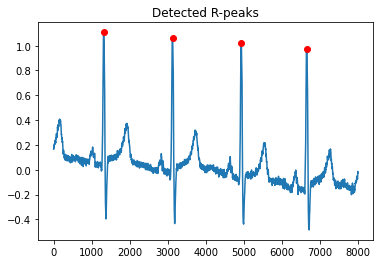

In [124]:
#detecting the R peaks from the ECG signal to detect heart rate
#use a library called ecgdetectors from Glasgov university
from ecgdetectors import Detectors

path='/scratch/lnw8px/ECG_radar/clinical/GDN0001/GDN0001_1_Resting.mat'
x = loadmat(path)
fs_ecg=x['fs_ecg'][0,0]
detectors = Detectors(fs_ecg)
ecg2=x['tfm_ecg2'].squeeze()
#select a part of the signal for easy visualization
sig=ecg2[8000:16000]
#detect R peaks with engzee_detector
#see https://github.com/berndporr/py-ecg-detectors for details
r_peaks = detectors.engzee_detector(sig)

plt.figure()
plt.plot(sig)
plt.plot(r_peaks, sig[r_peaks], 'ro')
plt.title('Detected R-peaks')

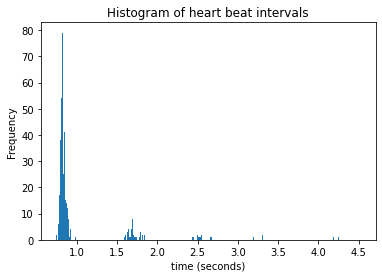

In [125]:
#get the time difference between r_peaks to calculate the time between two heart beats
sig=ecg2
r_peaks = detectors.engzee_detector(sig)

diffs=np.diff(r_peaks)
#convert this into time
heart_periods=diffs/fs_ecg

plt.hist(heart_periods, bins=500)
plt.xlabel('time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of heart beat intervals')
plt.show()

means period = 0.9983673805601319
sd of period = 0.48922556319882526


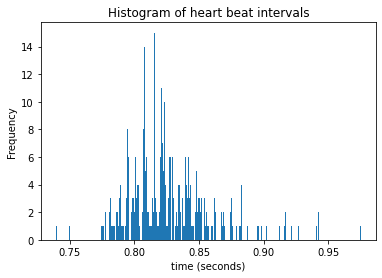

In [100]:
'''
Looks like there are outliers. It is very rare to have a heart rate less than 40 (1.5 seconds period between two heart beats).
Period cannot be too small either
So let's remove these outliers
Assume heart rate is from 40 - 200 bpm. This corresponds to 0.3 - 1.5 seconds
'''
print('means period = ' +str(np.mean(heart_periods)))
print('sd of period = ' +str(np.std(heart_periods)))

filt=heart_periods[(heart_periods<1.5) & (heart_periods>0.3)]

plt.hist(filt, bins=500)
plt.xlabel('time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of heart beat intervals')
plt.show()

In [127]:
get_avg_hr(filt_heart_period(heart_periods))

72.56570608799811

In [187]:
#function for fintering out like above
def filt_heart_period(heart_periods):
    filt=heart_periods[(heart_periods<1.5) & (heart_periods>0.3)]
    return filt
#get average heart rate (bpm) from heart periods
def get_avg_hr(heart_periods):
    avg_period=np.mean(heart_periods)
    hr=60/avg_period
    return hr

fs_ecg=2000
def get_periods_from_ECG(ecg):
    r_peaks = detectors.pan_tompkins_detector(ecg)
    diffs=np.diff(r_peaks)
    heart_periods=diffs/fs_ecg
    return heart_periods


    

In [107]:
flt=filt_heart_period(heart_periods)
get_avg_hr(flt)

72.56570608799811

In [109]:
'''
Let's see the variation of heart rate conditioned by different postures/activities
Actions : 
5_TiltDown
1_Resting
3_Apnea
4_TiltUp
2_Valsalva
'''
resting_df=dataframe[dataframe['action']==1]

In [188]:
resting_df=dataframe[dataframe['action']==1]
hr_periods=resting_df['ecg2'].reset_index(drop=True).apply(get_periods_from_ECG)
flt_periods=hr_periods.apply(filt_heart_period)
hr=flt_periods.apply(get_avg_hr)
print('--Resting--')
print('mean hr='+str(np.mean(hr.values)) + ' sd hr='+str(np.std(hr.values)))

valsalva_df=dataframe[dataframe['action']==2]
hr_periods=valsalva_df['ecg2'].reset_index(drop=True).apply(get_periods_from_ECG)
flt_periods=hr_periods.apply(filt_heart_period)
hr=hr_periods.apply(get_avg_hr)
print('--Valsalva--')
print('mean hr='+str(np.mean(hr.values)) + ' sd hr='+str(np.std(hr.values)))

apnea_df=dataframe[dataframe['action']==3]
hr_periods=apnea_df['ecg2'].reset_index(drop=True).apply(get_periods_from_ECG)
flt_periods=hr_periods.apply(filt_heart_period)
hr=hr_periods.apply(get_avg_hr)
print('--Apnea--')
print('mean hr='+str(np.mean(hr.values)) + ' sd hr='+str(np.std(hr.values)))

tiltup_df=dataframe[dataframe['action']==4]
hr_periods=tiltup_df['ecg2'].reset_index(drop=True).apply(get_periods_from_ECG)
flt_periods=hr_periods.apply(filt_heart_period)
hr=hr_periods.apply(get_avg_hr)
print('--Tiltup--')
print('mean hr='+str(np.mean(hr.values)) + ' sd hr='+str(np.std(hr.values)))

tiltdown_df=dataframe[dataframe['action']==5]
hr_periods=tiltdown_df['ecg2'].reset_index(drop=True).apply(get_periods_from_ECG)
flt_periods=hr_periods.apply(filt_heart_period)
hr=hr_periods.apply(get_avg_hr)
print('--Tiltdown--')
print('mean hr='+str(np.mean(hr.values)) + ' sd hr='+str(np.std(hr.values)))

'''
We can see that the different poses/activities of the participant may change the heart rate
For example, the hr is higher for tilted up position than tilted down position. 
In the paper this was attributed to Autonomous Nervous system activity
'''

--Resting--
mean hr=67.28423671079616 sd hr=16.271469122254896
--Valsalva--
mean hr=66.66633989151751 sd hr=11.468034573498597
--Apnea--
mean hr=84.59623308163657 sd hr=27.8018932045124
--Tiltup--
mean hr=86.77569506414297 sd hr=28.181306516047943
--Tiltdown--
mean hr=73.03630926817173 sd hr=29.077767984368986


In [20]:
resting_df=dataframe[dataframe['action']==1]
bp_array=resting_df['bp'].reset_index(drop=True).apply(np.mean).values
print('--Resting--')
print('mean bp='+str(np.mean(bp_array)) + ' sd bp='+str(np.std(bp_array)))

valsalva_df=dataframe[dataframe['action']==2]
bp_array=valsalva_df['bp'].reset_index(drop=True).apply(np.mean).values
print('--Valsalva--')
print('mean bp='+str(np.mean(bp_array)) + ' sd bp='+str(np.std(bp_array)))

apnea_df=dataframe[dataframe['action']==3]
bp_array=apnea_df['bp'].reset_index(drop=True).apply(np.mean).values
print('--Apnea--')
print('mean bp='+str(np.mean(bp_array)) + ' sd bp='+str(np.std(bp_array)))

tiltup_df=dataframe[dataframe['action']==4]
bp_array=tiltup_df['bp'].reset_index(drop=True).apply(np.mean).values
print('--Tiltup--')
print('mean bp='+str(np.mean(bp_array)) + ' sd bp='+str(np.std(bp_array)))

tiltdown_df=dataframe[dataframe['action']==5]
bp_array=tiltdown_df['bp'].reset_index(drop=True).apply(np.mean).values
print('--Tiltdown--')
print('mean bp='+str(np.mean(bp_array)) + ' sd bp='+str(np.std(bp_array)))

--Resting--
mean bp=83.51552667541314 sd bp=18.37728105649357
--Valsalva--
mean bp=87.94249696321016 sd bp=14.150848719298239
--Apnea--
mean bp=90.51209198566376 sd bp=14.271281078647531
--Tiltup--
mean bp=93.89125821016131 sd bp=12.672912634626554
--Tiltdown--
mean bp=87.02586387225841 sd bp=15.04544049606736


In [31]:
#calculate distance change from the radar signal
from scipy import signal
def get_phase_diff(signal1,signal2):
    x1h = signal.hilbert(signal1)
    x2h = signal.hilbert(signal2)
    c = np.inner( x1h, np.conjugate(x2h) ) / np.sqrt( np.inner(x1h,np.conjugate(x1h)) * np.inner(x2h,np.conjugate(x2h)) )
    phase_diff = np.angle(c)
    return phase_diff

def normalize(data):
    d=(data-np.min(data))/(np.max(data)-np.min(data))
    return d


In [55]:
resting_df=dataframe[dataframe['action']==1]
radarq=normalize(resting_df['radarq'].iloc[0])
radari=normalize(resting_df['radari'].iloc[0])

#filter radar signal
# Sample rate and desired cutoff frequencies (in Hz).
'''
do a band pass filtering. This removes artefacts dues to breathing (assumed less than 1.5Hz) and some of other noise 
of radar signal due to random bodily motions are backround radiation
'''
def butterworth(array):
    fs = 2000.0
    lowcut=1.5
    lc=lowcut/(fs/2)
    highcut = 20
    hc=highcut/(fs/2)
    array=normalize(array)
    b, a = signal.butter(4, [lc,hc], 'band')
    output = signal.filtfilt(b, a, array)
    return output


Text(0.5, 0, 'sample number')

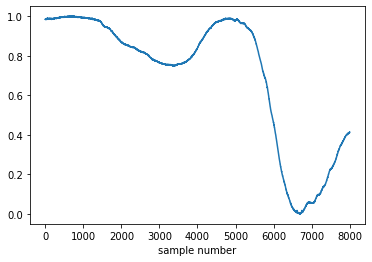

In [59]:
#before filtering
plt.plot(normalize(radarq[0:8000]))
plt.xlabel('sample number')

In [56]:
radarq_filt=butterworth(radarq)

Text(0.5, 0, 'sample number')

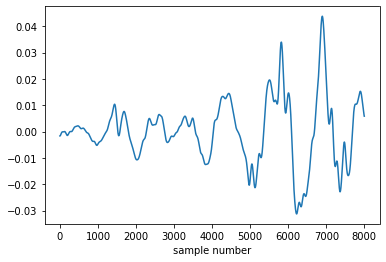

In [58]:
plt.plot(radarq_filt[0:8000])
plt.xlabel('sample number')

In [ ]:
'''
Low frequency variations were mainly due to breathing.
Once we filter them out structure of heart beat starts to show. But we need to do further processing to detect heart beat from radar
'''